100%|██████████| 6.25M/6.25M [00:00<00:00, 10.2MB/s]



0: 256x640 3 persons, 2 bicycles, 1 bus, 247.4ms
Speed: 3.7ms preprocess, 247.4ms inference, 1578.0ms postprocess per image at shape (1, 3, 256, 640)


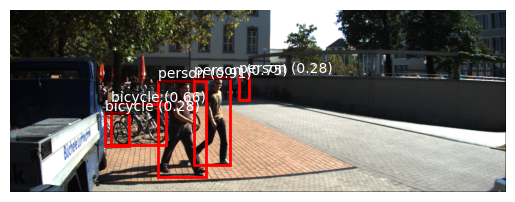

In [1]:
import torch
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Step 1: Load a pretrained YOLOv8 model
model = YOLO("yolov8n.pt")  # using YOLOv8n for faster inference; you can change to yolov8s.pt or yolov8m.pt for better accuracy

# Function to visualize detections with semi-transparent labels
def plot_detections(img, results):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    for result in results:
        box = result['box']
        label = result['label']
        confidence = result['confidence']
        
        # Draw rectangle and label
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="red", linewidth=2)
        ax.add_patch(rect)
        
        # Semi-transparent background for text
        text_x, text_y = box[0], box[1]
        text = f"{label} ({confidence:.2f})"
        
        # Add a semi-transparent rectangle as the background
        bg_rect = plt.Rectangle((text_x, text_y - 12), width=100, height=16, color="black", alpha=0.5)
        ax.add_patch(bg_rect)
        
        # Add text on top of the rectangle
        plt.text(text_x, text_y, text, color="white", fontsize=10, verticalalignment="bottom")

    plt.axis("off")
    plt.show()

# Step 2: Test the pretrained model on a sample image
def test_model_on_image(model, image_path):
    img = cv2.imread(image_path)
    results = model(img)  # Inference
    processed_results = [
        {
            'box': [int(b) for b in box.xyxy[0].tolist()],
            'label': model.names[int(box.cls[0])],
            'confidence': box.conf[0].item()
        }
        for box in results[0].boxes
        if model.names[int(box.cls[0])] in ["person", "car", "bicycle"]  # Only display relevant classes
    ]
    plot_detections(img, processed_results)

# Test the pretrained model on your custom image
test_image_path = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data/0000000000.png"
test_model_on_image(model, test_image_path)



image_directory = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data"

# loading the image results and displaying them as a video

def images_to_video(image_dir, video_path, fps=30):
    images = [img for img in os.listdir(image_dir) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_dir, image)))

    cv2.destroyAllWindows()
    video.release()

# Convert the images to a video
video_path = "output.mp4"
images_to_video(image_directory, video_path, fps=30)





0: 256x640 3 persons, 2 bicycles, 1 bus, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 640)


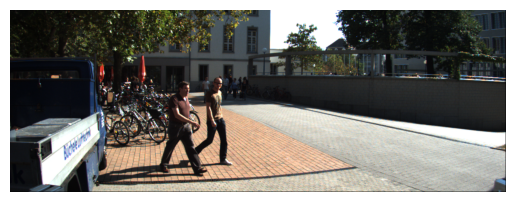


0: 256x640 3 persons, 2 bicycles, 1 bus, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 4 persons, 1 bicycle, 1 bus, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 2 persons, 1 bicycle, 1 bus, 13.7ms
Speed: 1.8ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 2 persons, 3 bicycles, 1 bus, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 3 persons, 3 bicycles, 1 bus, 1 truck, 10.5ms
Speed: 3.5ms preprocess, 10.5ms inference, 2.6ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 2 persons, 3 bicycles, 1 bus, 1 truck, 8.7ms
Speed: 1.4ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 3 persons, 2 bicycles, 1 bus, 1 truck, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 2.1ms postpro

In [5]:
import torch
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# Step 1: Load a pretrained YOLOv8 model
model = YOLO("yolov8n.pt")  # Using YOLOv8n for faster inference

# Initialize DeepSORT
tracker = DeepSort(max_age=30, n_init=3, nn_budget=100)

# Function to visualize detections with semi-transparent labels
# Updated draw function
def plot_detections(img, tracked_objects):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax = plt.gca()

    for obj in tracked_objects:
        if not obj.is_confirmed():
            continue
        
        track_id = obj.track_id
        # Use bbox from `to_ltwh` method (left, top, width, height)
        bbox = obj.to_ltwh()  
        label = obj.get_det_class()  # Use DeepSORT's method to get the class id
        label_name = model.names[label] if label < len(model.names) else "unknown"
        
        # Draw bounding box and label
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color="red", linewidth=2)
        ax.add_patch(rect)
        
        text_x, text_y = bbox[0], bbox[1]
        text = f"ID {track_id} - {label_name}"
        
        # Draw label with background
        bg_rect = plt.Rectangle((text_x, text_y - 12), width=150, height=16, color="black", alpha=0.5)
        ax.add_patch(bg_rect)
        plt.text(text_x, text_y, text, color="white", fontsize=10, verticalalignment="bottom")
    
    plt.axis("off")
    plt.show()



# Step 2: Detect and Track Objects
def detect_and_track(model, image_path):
    img = cv2.imread(image_path)
    results = model(img)  # YOLO inference
    
    # Process YOLO detections
    detections = []
    for box in results[0].boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        if label in ["person", "car", "bicycle"]:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            confidence = box.conf[0].item()
            detections.append(([x1, y1, x2 - x1, y2 - y1], confidence, cls, label))  # (bbox, confidence, class_id, label)

    # Update DeepSORT tracker
    tracked_objects = tracker.update_tracks(detections, frame=img)

    # Visualize results
    plot_detections(img, tracked_objects)


# Test the model on an image
test_image_path = "/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data/0000000000.png"
detect_and_track(model, test_image_path)

# Video Tracking Function
def process_video(image_dir, output_path, fps=30):
    images = sorted([img for img in os.listdir(image_dir) if img.endswith(".png")])
    frame = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, _ = frame.shape
    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        results = model(img)  # YOLO Inference
        
        # Prepare detections for DeepSORT
        detections = []
        class_ids = []
        labels = []
        for box in results[0].boxes:
            cls = int(box.cls[0])
            label = model.names[cls]
            if label in ["person", "car", "bicycle"]:
                x1, y1, x2, y2 = [int(b) for b in box.xyxy[0].tolist()]
                confidence = box.conf[0].item()
                detections.append(([x1, y1, x2 - x1, y2 - y1], confidence, cls))
                class_ids.append(cls)
                labels.append(label)
        
        # Update tracks
        tracked_objects = tracker.update_tracks(detections, frame=img)
        
        # Annotate frame with tracking info
        for obj in tracked_objects:
            track_id = obj.track_id
            bbox = obj.to_ltwh()
            class_id = obj.det_class_id if hasattr(obj, 'det_class_id') else None
            label = model.names[class_id] if class_id is not None else "unknown"

            # Draw bounding box and label
            cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), 
                          (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), 
                          (0, 255, 0), 2)
            text = f"ID {track_id} - {label}"
            cv2.putText(img, text, (int(bbox[0]), int(bbox[1]) - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        video_writer.write(img)
    
    video_writer.release()


# Process the video
output_video_path = "tracked_output.mp4"
process_video("/home/teitur/perception/Project/34759_final_project_raw/seq_01/image_02/data", output_video_path)
